In [35]:
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import matplotlib.pyplot as plt
from astropy.table import Column, join, Table, vstack, hstack
from astropy.io import ascii
from HMXB_pipeline_class import pipeline
import astropy.coordinates as coords
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
import corner
from datetime import datetime
import os

In [36]:
from Galactic_traceback import GalacticTraceback

In [37]:
today = datetime.now().strftime("%Y%m%d")

# Colors

In [38]:
    color_map = {
        "xkcd:blue": "O I-III",
        "xkcd:red": "B I-III",
        "xkcd:bright Blue": "Oe I-III",
        "xkcd:dark blue": "Oe IV-V",
        "xkcd:green": "B0e I-III",
        "xkcd:bright green": "B1e I-III",
        "xkcd:grass green": "B2e I-III",
        "xkcd:black": "OB IV-V",
        "xkcd:grey": "M,A,None",
        "xkcd:purple": "B0e IV-V",
        "xkcd:light purple": "B1e IV-V",
        "xkcd:dark purple": "B2e IV-V",
    }
    groups = [
        ("O I-III", ['xkcd:blue'], 'xkcd:blue'),
        ("B I-III", ['xkcd:red'], 'xkcd:red'),
        ("Oe", ['xkcd:bright Blue', 'xkcd:dark blue'], 'xkcd:cobalt'),
        ("Be I-III", ['xkcd:green', 'xkcd:bright green', 'xkcd:dark green'], 'xkcd:green')
    ]
    marker_map = {
        "xkcd:blue": 'o',   # Circle marker for "O I-III"
        "xkcd:red":'o',    # Circle marker for "B I-III"
        "xkcd:bright Blue": '^',  # Triangle marker for "Oe I-III"
        "xkcd:dark blue":'^',  # Triangle marker for "Oe IV-V"
        "xkcd:green": '^',  # Circle marker for "B0e I-III"
        "xkcd:bright green": '^',  # Circle marker for "B1e I-III"
        "xkcd:grass green":'^',  # Circle marker for "B2e I-III"
        "xkcd:black": 'x',   # Cross marker for "OB IV-V"
        "xkcd:grey": 'x',  # Cross marker for "M,A,None"
        "xkcd:purple": '^',  # Circle marker for "B0e IV-V"
        "xkcd:light purple": '^',  # Circle marker for "B1e IV-V"
        "xkcd:dark purple": '^'  # Circle marker for "B2e IV-V"
    }

# DNE This file

In [39]:
cwd = os.getcwd()
home_files = os.path.dirname(cwd)
home_files = home_files + '/'
csv_files  = home_files + 'DATA/'
csv_files

'/home/karan/Documents/UvA/Thesis/DATA/'

In [40]:
#HMXB_read = ascii.read(home_files+'HMXB_practice_analysis.ecsv',format='ecsv')
HMXB_read = ascii.read(csv_files+f'HMXB_{today}_.csv',format='csv')

In [41]:
HMXB_trace = HMXB_read

In [42]:
HMXB_trace

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,dist_err,SpType,Mod_SpType,SpColor,Name,Mx,Mx_err,Mo,Mo_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,str23,float64,float64,float64,float64
3441207615229815040,84.72739245821431,0.020250700414180756,26.31577524440175,0.015788812190294266,-0.5898287895613142,0.030902111902832985,-2.879557993302878,0.01621093973517418,0.5245380785708109,0.023250581696629524,-60.0,nan,8.601999282836914,181.44504956690048,-2.643537066457817,8.987546920776367,8.01044750213623,0.9770994186401367,1.9064392860183996,2.12603198111763,-2.0297143279424583,10.403915664294958,225.02622744453242,-4.5772627558119305,1.4743856024086786,-0.7832807603717467,-0.0025775251985549665,0.005181971135181485,12.762149422593925,0.6542239039075064,-1.2516155387058931,0.08450448914978252,O9.7IIIe,xkcd:bright blue,xkcd:blue,1A 0535+262,--,--,20.0,--
5336957010898124160,170.23817252151974,0.008774157613515854,-61.91670671055608,0.009544741362333298,-5.421032061547652,0.012438164092600346,1.3700031073878873,0.011767985299229622,0.32925822598102933,0.011463727802038193,nan,nan,11.589363098144531,292.49852714674694,-0.8918067117070271,12.270934104919434,10.759902000427246,1.5110321044921875,3.03712989104672,-5.567951674993604,-0.5122609408455543,7.8560253894545635,222.56671751604506,-220.47262223549708,-1.054611102383597,-0.5187441308440925,-5.428597657240247,-0.018013469887746873,13.18075554666247,0.9152570846302401,0.024496659886285126,0.10574323622942539,O9.5Ve,xkcd:dark blue,xkcd:blue,1A 1118-61,--,--,--,--
5334851450481641088,176.86894042633617,0.007541968487203121,-61.953719225831875,0.008998828940093517,-6.225580251990721,0.01041429303586483,2.361537685037365,0.011920752003788948,0.12669559944899778,0.010234012268483639,nan,nan,12.255293846130371,295.48972809721556,-0.00970401441105653,13.309616088867188,11.227763175964355,2.081852912902832,7.892933964155221,-6.606609744728988,0.8291063820044122,8.763800120419218,223.52091675977692,-193.7528220168817,-0.4170130760677609,-0.20310608662182214,-5.372222021128227,2.7060920841833756e-05,49.25833635059616,-0.8173746475330006,1.0321854077053925,0.6375626570677606,B2Iae,xkcd:dark green,xkcd:green,1E 1145.1-6141,1.7,0.3,14.0,4.0
6053076566300433920,183.31156879290245,0.012357387691736221,-64.87513252303748,0.015193149447441101,-5.95305662663964,0.01588580757379532,0.449629791184431,0.02075292356312275,0.26448691327892004,0.01766935922205448,nan,nan,13.976888656616211,298.89007133029565,-2.303521643360621,14.39801025390625,13.351907730102539,1.046102523803711,3.7809054051208566,-5.958118420264099,-0.37666303137996027,7.449418244846888,222.10444742848472,-219.8306787168525,-0.8942614068632253,-0.40872604268783935,-5.393397656845806,-0.06092405130983405,6.1364723359412885,0.3295406434449326,0.09298706261771314,0.25258783113112304,B5V,xkcd:red,xkcd:red,1ES 1210-64.6,--,--,--,--
5255509901121774976,154.7315592681715,0.00934557057917118,-58.94609420856299,0.009438585489988327,-6.454306520313594,0.013439311645925045,2.256007949459996,0.01335159968584776,0.2273178405234294,0.010232986882328987,nan,nan,12.269230842590332,284.351776705235,-1.6900802660463154,12.882477760314941,11.495985984802246,1.3864917755126953,4.3991267807989365,-6.6488043210162475,-1.5940657536704546,8.547292409868648,223.3022676369862,-212.96405708690497,-0.6634443517918205,-0.34946803248438035,-5.444675837248132,0.0016679885391937266,28.32721701626133,-0.5406841319762945,-1.246265

In [43]:
#make a sample
HMXB_sample = HMXB_trace[1:20]
HMXB_sample

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,dist_err,SpType,Mod_SpType,SpColor,Name,Mx,Mx_err,Mo,Mo_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,str23,float64,float64,float64,float64
5336957010898124160,170.23817252151974,0.008774157613515854,-61.91670671055608,0.009544741362333298,-5.421032061547652,0.012438164092600346,1.3700031073878873,0.011767985299229622,0.32925822598102933,0.011463727802038193,nan,nan,11.589363098144531,292.49852714674694,-0.8918067117070271,12.270934104919434,10.759902000427246,1.5110321044921875,3.03712989104672,-5.567951674993604,-0.5122609408455543,7.8560253894545635,222.56671751604506,-220.47262223549708,-1.054611102383597,-0.5187441308440925,-5.428597657240247,-0.018013469887746873,13.18075554666247,0.9152570846302401,0.024496659886285126,0.10574323622942539,O9.5Ve,xkcd:dark blue,xkcd:blue,1A 1118-61,--,--,--,--
5334851450481641088,176.86894042633617,0.007541968487203121,-61.953719225831875,0.008998828940093517,-6.225580251990721,0.01041429303586483,2.361537685037365,0.011920752003788948,0.12669559944899778,0.010234012268483639,nan,nan,12.255293846130371,295.48972809721556,-0.00970401441105653,13.309616088867188,11.227763175964355,2.081852912902832,7.892933964155221,-6.606609744728988,0.8291063820044122,8.763800120419218,223.52091675977692,-193.7528220168817,-0.4170130760677609,-0.20310608662182214,-5.372222021128227,2.7060920841833756e-05,49.25833635059616,-0.8173746475330006,1.0321854077053925,0.6375626570677606,B2Iae,xkcd:dark green,xkcd:green,1E 1145.1-6141,1.7,0.3,14.0,4.0
6053076566300433920,183.31156879290245,0.012357387691736221,-64.87513252303748,0.015193149447441101,-5.95305662663964,0.01588580757379532,0.449629791184431,0.02075292356312275,0.26448691327892004,0.01766935922205448,nan,nan,13.976888656616211,298.89007133029565,-2.303521643360621,14.39801025390625,13.351907730102539,1.046102523803711,3.7809054051208566,-5.958118420264099,-0.37666303137996027,7.449418244846888,222.10444742848472,-219.8306787168525,-0.8942614068632253,-0.40872604268783935,-5.393397656845806,-0.06092405130983405,6.1364723359412885,0.3295406434449326,0.09298706261771314,0.25258783113112304,B5V,xkcd:red,xkcd:red,1ES 1210-64.6,--,--,--,--
5255509901121774976,154.7315592681715,0.00934557057917118,-58.94609420856299,0.009438585489988327,-6.454306520313594,0.013439311645925045,2.256007949459996,0.01335159968584776,0.2273178405234294,0.010232986882328987,nan,nan,12.269230842590332,284.351776705235,-1.6900802660463154,12.882477760314941,11.495985984802246,1.3864917755126953,4.3991267807989365,-6.6488043210162475,-1.5940657536704546,8.547292409868648,223.3022676369862,-212.96405708690497,-0.6634443517918205,-0.34946803248438035,-5.444675837248132,0.0016679885391937266,28.32721701626133,-0.5406841319762945,-1.2462657097252678,0.19803200020711922,O6V((f)),xkcd:blue,xkcd:blue,1FGL J1018.6-5856,2.0,--,22.9,--
1979911002134040960,330.4091919702234,0.0112070357427001,50.16795238313883,0.011057302355766296,2.364625293266044,0.014718983322381973,-0.2937024864956449,0.013353955931961536,0.8781947661310571,0.013396814465522766,nan,nan,9.304606437683105,97.24776932144769,-4.041208697923339,9.407649040222168,9.073572158813477,0.3340768814086914,1.1386995670739004,1.7284177853776819,-1.6402090986570457,8.716439817701456,223.47353491258164,213.5213484311505,2.3028503458441034,-1.5629398824262077,-5.196815291195641,-0.07075834955835932,24.94903946557588,4.622382730729219,-0.00651086667247861

# Check with Mitchel's System

In [44]:
x = HMXB_trace[HMXB_trace['Name'] == 'LS 5039']

In [45]:
x['radial_velocity'] = 11.91
x['radial_velocity_error'] =1.12

In [46]:
x

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,dist_err,SpType,Mod_SpType,SpColor,Name,Mx,Mx_err,Mo,Mo_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,str23,float64,float64,float64,float64
4104196427943626624,276.5627681201673,0.012748370878398418,-14.848438248314068,0.011323812417685986,7.425312749534734,0.01417446881532669,-8.151225884328909,0.011673848144710064,0.4900256100180399,0.015014423057436943,11.91,1.12,10.798686027526855,16.881564472210624,-1.2892552605096488,11.453262329101562,9.997603416442871,1.4556589126586914,2.040709668139969,-3.7327492501273345,-10.375178836117982,6.574474121237763,221.02147493835528,82.3370934667535,-1.0211634982115043,-0.8187214502727357,-0.6839039104181559,0.04352303720065744,94.90903787694724,-2.0276818414976745,-9.599980423045903,0.0625275040088767,ON6V((f))z,xkcd:blue,xkcd:blue,LS 5039,--,--,23.0,--


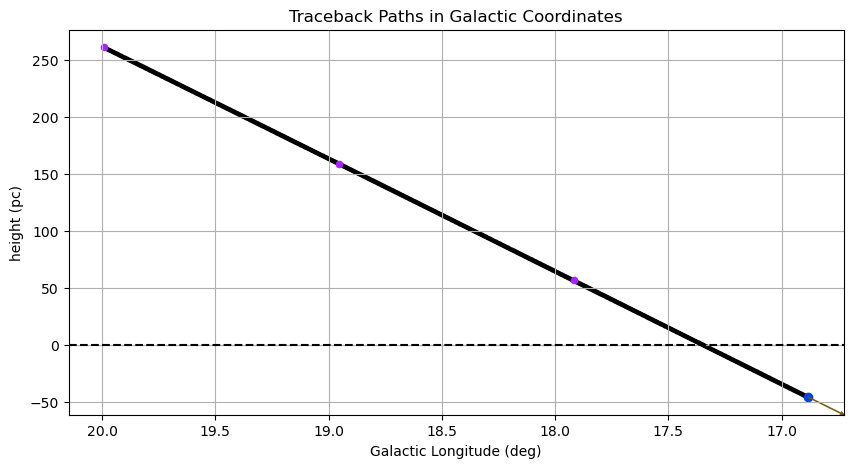

In [47]:
GalacticTraceback(x).plot_trace(savefig=False)

# Check with 1700-37

In [48]:
star_170037 =HMXB_trace[HMXB_trace['Name'] == 'HD 153919']
star_170037
#star_170037.write(home_files+"DATA/1700_37.csv",format='ascii.csv',overwrite=True)

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,dist_err,SpType,Mod_SpType,SpColor,Name,Mx,Mx_err,Mo,Mo_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,str23,float64,float64,float64,float64
5976382915813535232,255.9865659301791,0.021049443632364273,-37.8441202722809,0.012138224206864834,2.4137032635492046,0.028064759448170662,5.021949969731823,0.021347088739275932,0.6327358617075665,0.02594889886677265,-60.0,nan,6.420469760894775,347.75444710988126,2.173492429913019,6.575953483581543,6.088586330413818,0.4873671531677246,1.5804383163952436,5.459355496184255,1.114173464609666,6.9646916981903955,221.52058975292903,-56.84609840595855,-2.079921136161054,-0.974954593248736,-0.333036617639879,0.052075832776272056,60.9160634716124,7.872313249985188,2.03705222508213,0.06481477741223182,O6Iafcp,xkcd:blue,xkcd:blue,HD 153919,--,--,--,--


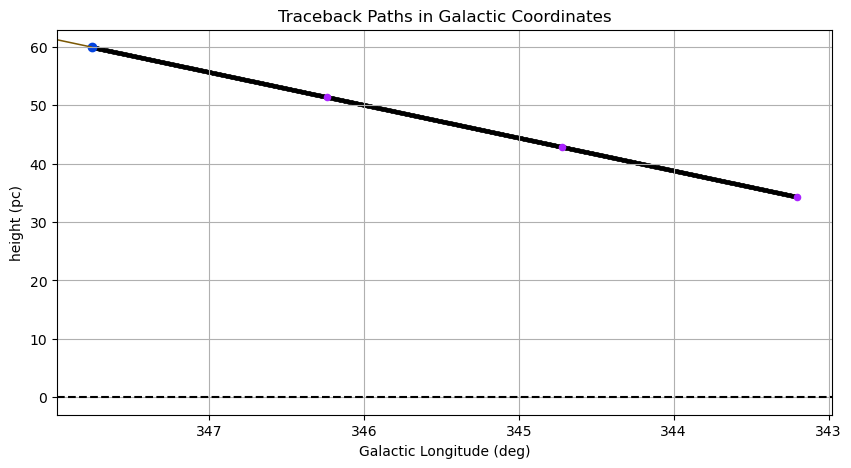

In [15]:
GalacticTraceback(star_170037).plot_trace(savefig=False)

In [16]:
ankay = ascii.read(csv_files+'/Ankay Stars-result.ecsv',format='ecsv')
ankay

source_id,l,b,parallax,parallax_error,ra,dec
,deg,deg,mas,mas,deg,deg
int64,float64,float64,float64,float32,float64,float64
2006888825592397440,105.32327905924795,-1.2939935497081787,0.3483052202515175,0.014516796,339.2247839218438,56.90581642753408
5620657678322625920,263.0582466143229,3.9298644181968547,0.49623999190934365,0.015160984,135.5285587975077,-40.55465296117549
5964986649547042944,343.0275230251908,0.8699789528790719,0.5855000591336458,0.11761477,253.49886248281086,-42.36204478621972
5966450786728068736,343.3618117479257,0.8883494689552196,0.615508231687669,0.03835648,253.76386970004768,-42.09084066377716
5966501501704611840,343.31111778593646,1.1041026694967573,0.5927086633224053,0.043056734,253.49521753918265,-41.994337526197754
5966509885480902656,343.4644354566207,1.1839131606480862,0.6916798090200686,0.0316925,253.541921539563,-41.825049016900444
5966510057279631488,343.46279853725764,1.2154956900689977,0.1598843584599856,0.34058267,253.50765128170775,-41.806400365822114
5966563486675142912,344.0836145646463,1.4908505152976395,0.5416667036863951,0.050578304,253.7437684795529,-41.15086637583546


In [17]:
#GalacticTraceback(star_170037).plot_with_cluster(star_170037['source_id'],ankay,savefig=False)

In [18]:
scoob1 = ascii.read(csv_files+'/SCO OB1-result.ecsv')

Initial position: l=        l         
------------------
347.75444710988126, b=        b        
-----------------
2.173492429913019
Orbit start: l=358.0151158723451, b=0.3784379788376614


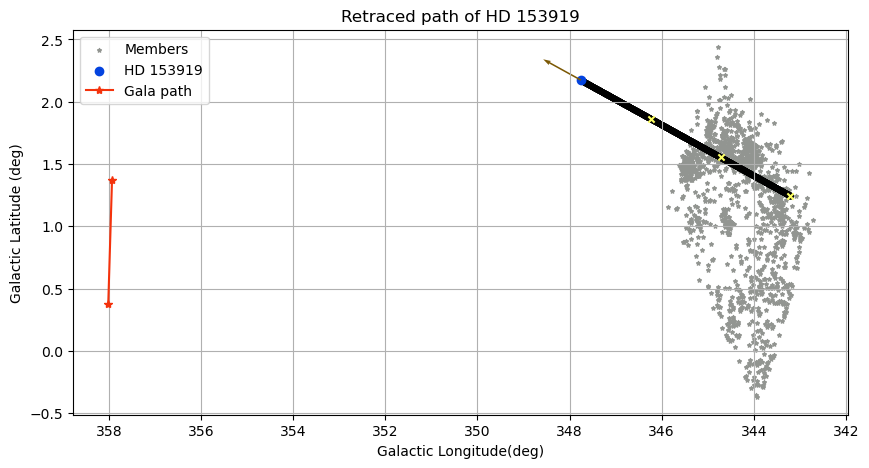

In [19]:

GalacticTraceback(star_170037).plot_with_cluster(star_170037['source_id'],scoob1,savefig=False)

# Converting astropy table list to float. Used in Galactic_traceback

very dumb

In [20]:
# x = HMXB_sample[HMXB_sample['source_id'] == 427234969757165952]
# #float(x['l'][0])
# l = float(x['l'][0])
# l


In [21]:
HMXB_sample = GalacticTraceback(HMXB_sample).traceback_time()

In [22]:
HMXB_trace = GalacticTraceback(HMXB_trace).traceback_time()

In [23]:
HMXB_trace.write(home_files+f"Trace_{today}.csv",format='ascii.csv',overwrite=True)

In [24]:
# GalacticTraceback(HMXB_sample).plot_trace(savefig=False)

0 11


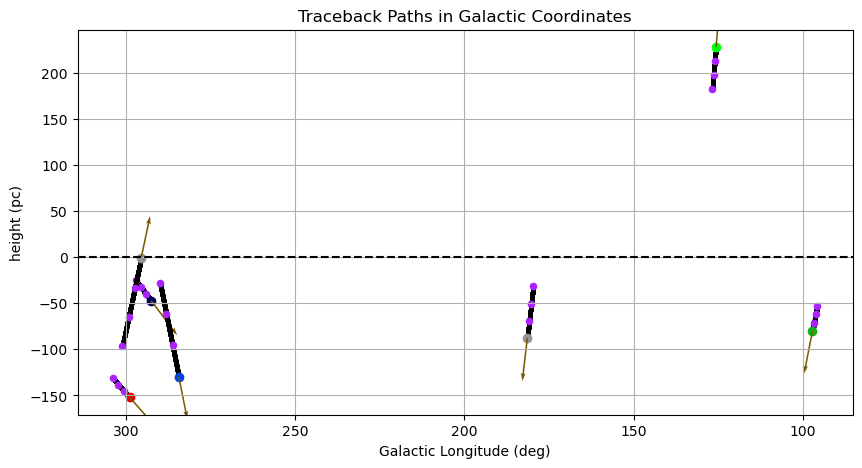

11 22


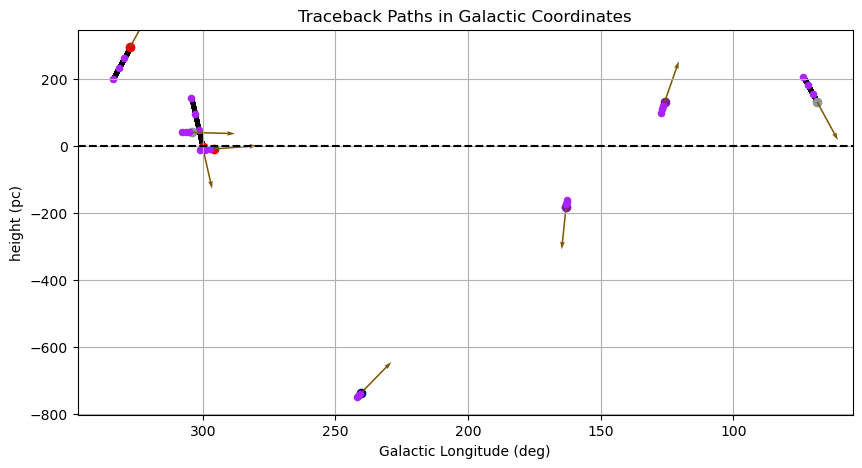

22 33


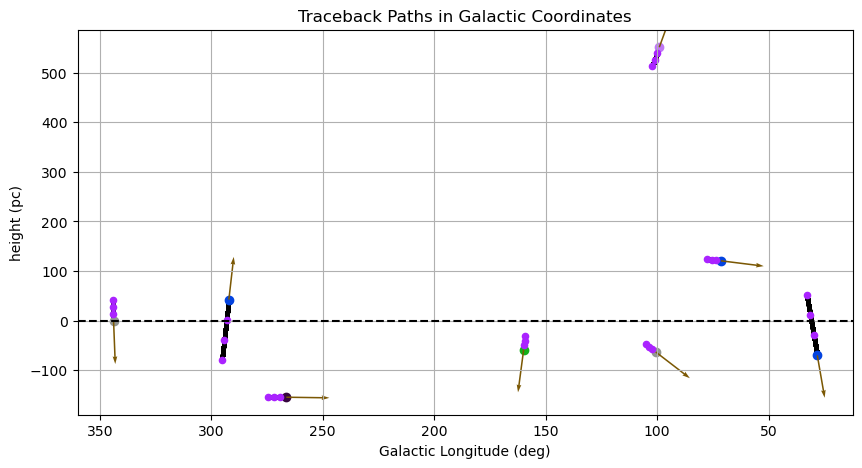

33 44


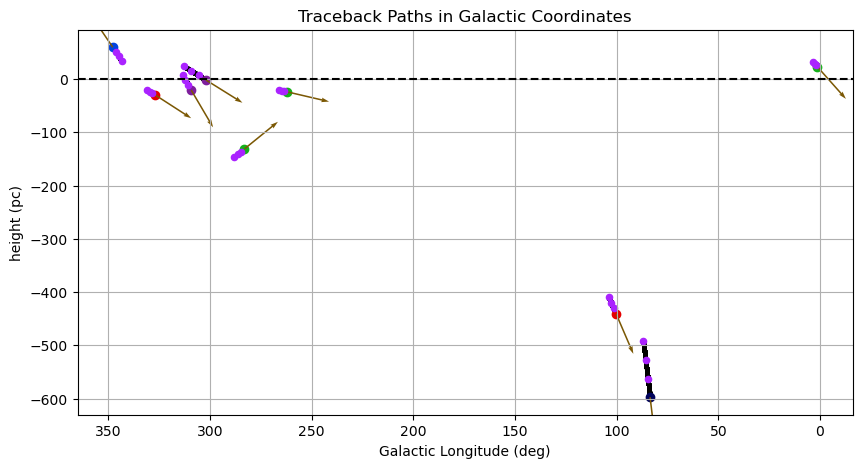

44 55


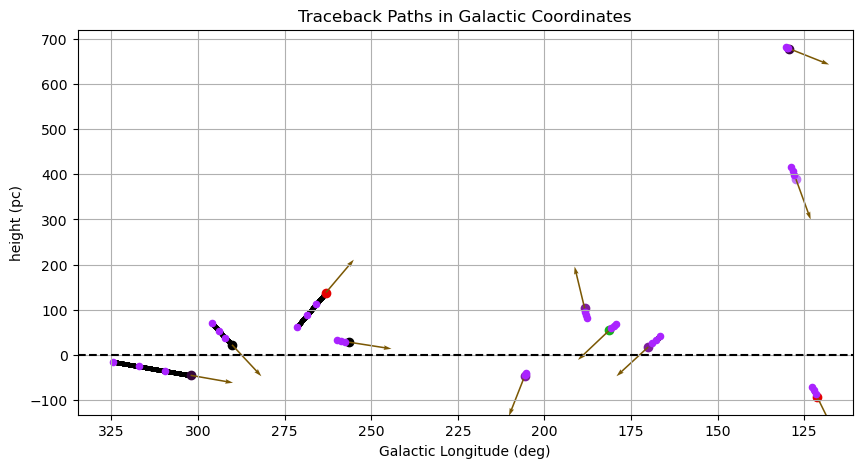

55 66


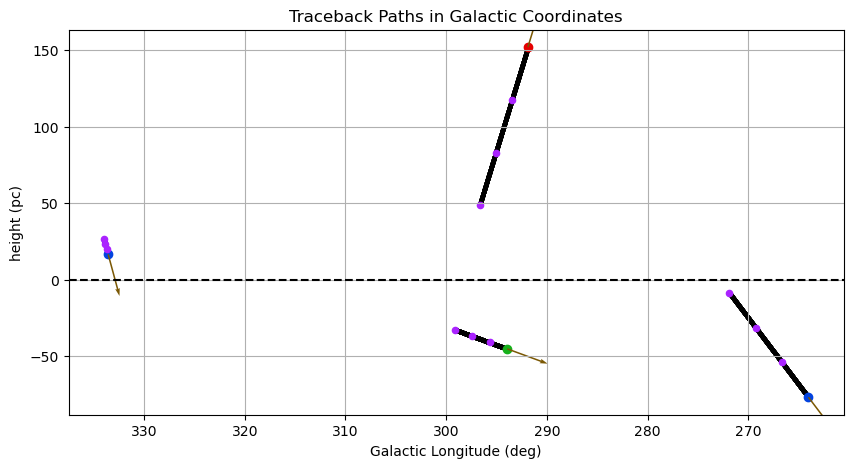

66 77


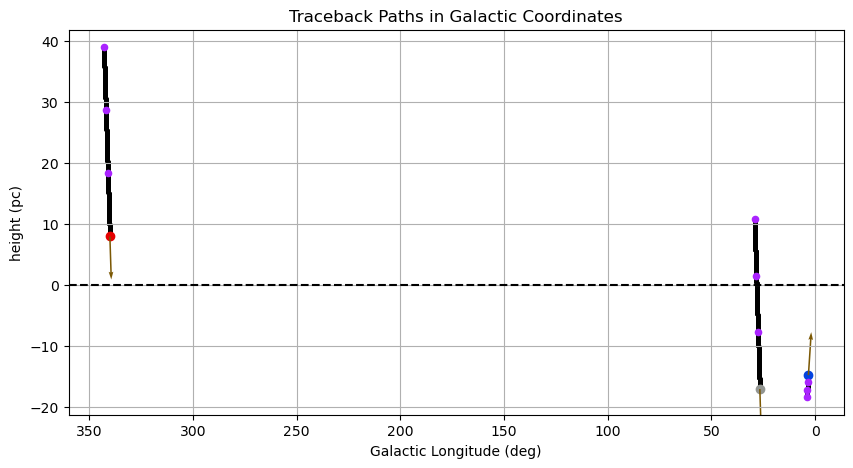

77 88


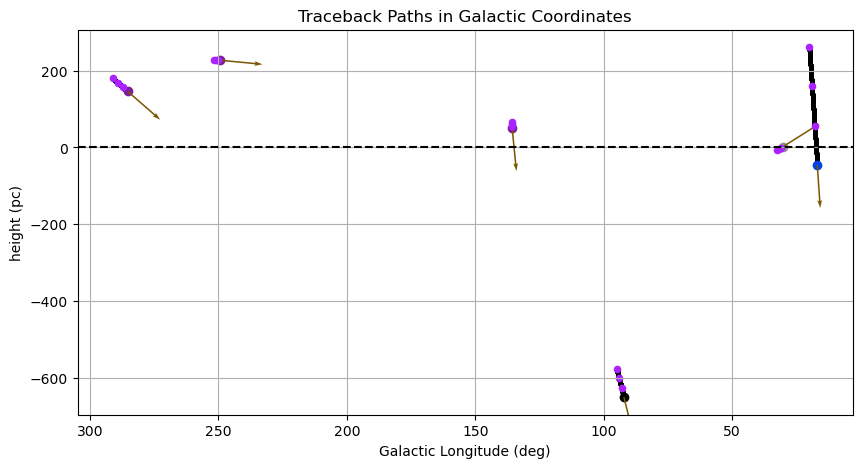

88 99


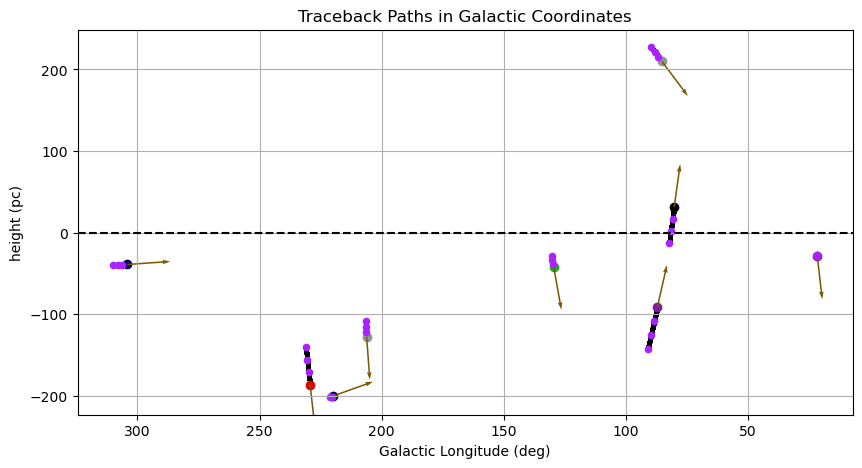

99 110


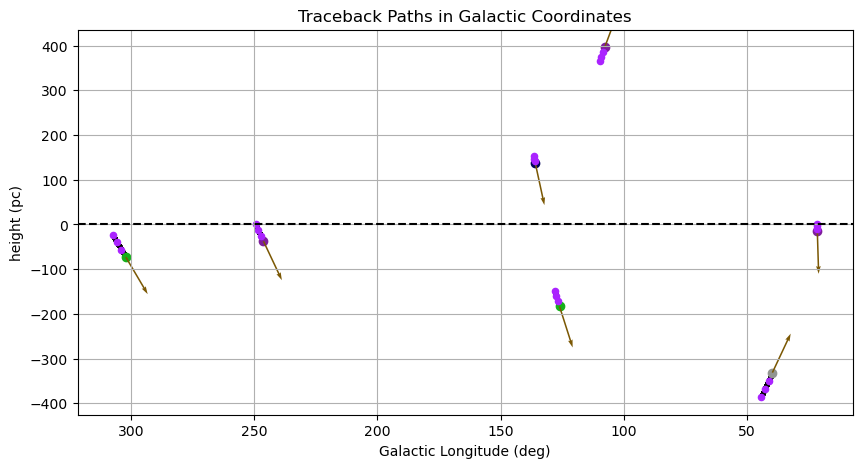

110 121


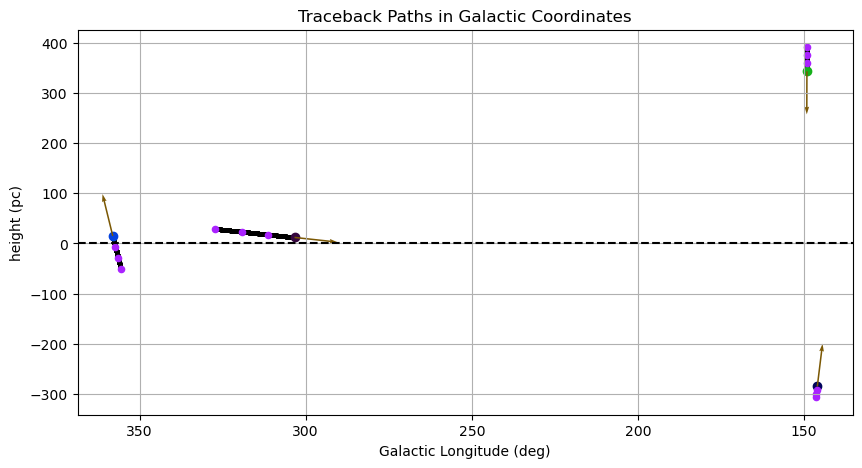

In [25]:
see_idx = np.linspace(0,121,12)
see_idx 

for i in range(len(see_idx)-1):
    a = int(see_idx[i])
    b = int(see_idx[i+1])
    print(a,b)
    GalacticTraceback(HMXB_trace[a:b]).plot_trace(savefig=False)
    

In [26]:
intersting_index = [5,9,14,16,35,42,47,74,105]
#for indexing subtract 2
intersting_index = [x -2 for x in intersting_index]
intersting_index
interesting_stars = HMXB_trace[intersting_index]

In [27]:
interesting_stars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,dist_err,SpType,Mod_SpType,SpColor,Name,Mx,Mx_err,Mo,Mo_err,Trace Time
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Million years
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,str23,float64,float64,float64,float64,float64
6053076566300433920,183.31156879290245,0.012357387691736221,-64.87513252303748,0.015193149447441101,-5.95305662663964,0.01588580757379532,0.449629791184431,0.02075292356312275,0.26448691327892004,0.01766935922205448,nan,nan,13.976888656616211,298.89007133029565,-2.303521643360621,14.39801025390625,13.351907730102539,1.046102523803711,3.7809054051208566,-5.958118420264099,-0.37666303137996027,7.449418244846888,222.10444742848472,-219.8306787168525,-0.8942614068632253,-0.40872604268783935,-5.393397656845806,-0.06092405130983405,6.1364723359412885,0.3295406434449326,0.09298706261771314,0.25258783113112304,B5V,xkcd:red,xkcd:red,1ES 1210-64.6,--,--,--,--,22.01617155184249
2033989790047905024,300.09104899633587,0.014430977404117584,32.18973933161206,0.017375720664858818,-2.850743997098801,0.02021029405295849,-4.300169718523636,0.023098601028323174,0.06746486507910339,0.021092984825372696,nan,nan,15.064558029174805,68.98602751827119,1.1341894069944143,16.446447372436523,13.904094696044922,2.5423526763916016,14.82253019890409,-5.158080851424149,0.11136819686971562,14.196091749210199,227.77929350001756,125.28525571703477,0.07408075150879062,-0.1034825141147826,-3.7200864746749893,0.023215381902318248,107.08637018851347,-1.5120751282579503,0.19163532908217995,4.634284885807226,early BV or mid BIII,xkcd:black,xkcd:grey,2MASS J20002185+3211232,--,--,--,--,36.66290718486261
5863533199843070208,195.3211964950643,0.008986628614366055,-61.601844813228226,0.010867293924093246,-4.340692264055244,0.012104980647563934,-0.236113209203886,0.015209818258881569,0.5395135891716509,0.014079692773520947,nan,nan,12.647679328918457,304.10270102486777,1.247518814190948,13.952112197875977,11.51938533782959,2.4327268600463867,1.853521431286583,-4.347010190708723,-0.029345879849095056,7.617165624120326,222.29802684324054,-203.57831776442197,-1.885792053660202,-0.8777385436878964,-4.465672113389193,0.052320373983196805,18.948532730150035,2.004453976340672,0.7960722898556045,0.0483713715936614,B2 Vne,xkcd:dark green,xkcd:green,3U 1258-61,--,--,--,--,-153.03912352199944
168450545792009600,58.84615062234396,0.02955361269414425,31.045836091857545,0.02079164795577526,-1.282117252826291,0.05307381600141525,-1.8690907560201113,0.030308086425065994,1.627402622661778,0.03745640814304352,nan,nan,6.261696815490723,163.0813533466715,-17.136203125538678,6.439853668212891,5.930059909820557,0.509793758392334,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.063394189676286,223.81506681128036,57.77572175230654,5.54632682187915,-1.8486200400580908,-0.4202484622115612,-0.4025983375739546,14.02859774983416,-4.8164893827016515,0.0058944434132315315,0.014142822981115537,B0Ve,xkcd:purple,xkcd:green,4U 0352+309,--,--,--,--,27.475025011659326
2063791369815322752,308.0636268551211,0.06144415959715843,37.63743239546562,0.07595060020685196,-3.370917952976648,0.08323334902524948,-5.400072973224192,0.09149152785539627,0.3418462523155139,0.08463052660226822,nan,nan,16.891359329223633,77.15184001171907,-1.241801183457772,19.491252899169922,15.41940975189209,4.071843147277832,2.9252916866177308,-6.342133523384574,-0.5488336117697298,8.351500106687862,223.09990827768783,219.23726674218403,

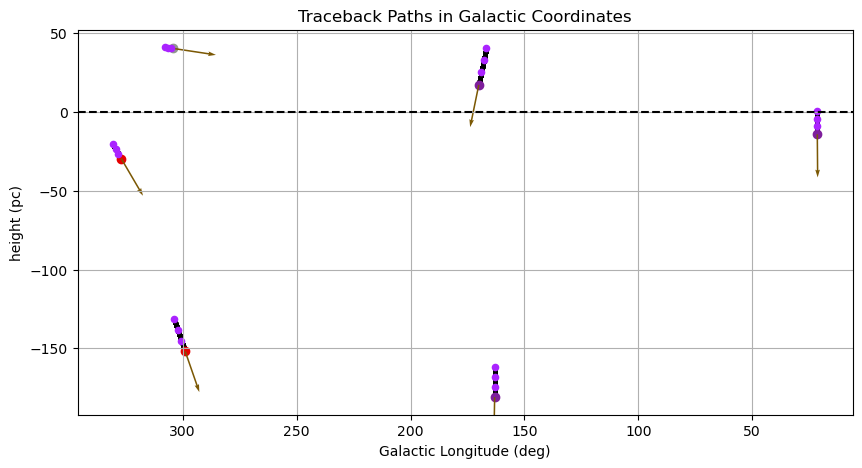

In [28]:
GalacticTraceback(interesting_stars).plot_trace(savefig=False)

In [29]:
HMXB_sample.write(home_files+"DATA/sample_path.csv",format='ascii.csv',overwrite=True)

In [30]:
leaving_stars_mask = HMXB_trace['Trace Time'] > 0
leaving_stars = HMXB_trace[leaving_stars_mask]
leaving_stars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,distance,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,mu_l_rot,mu_b_rot,Peculiar Velocity,peculiar_mu_l,peculiar_mu_b,dist_err,SpType,Mod_SpType,SpColor,Name,Mx,Mx_err,Mo,Mo_err,Trace Time
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Million years
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,str23,float64,float64,float64,float64,float64
3441207615229815040,84.72739245821431,0.020250700414180756,26.31577524440175,0.015788812190294266,-0.5898287895613142,0.030902111902832985,-2.879557993302878,0.01621093973517418,0.5245380785708109,0.023250581696629524,7.0,nan,8.601999282836914,181.44504956690048,-2.643537066457817,8.987546920776367,8.01044750213623,0.9770994186401367,1.9064392860183996,2.12603198111763,-2.0297143279424583,10.403915664294958,225.02622744453242,-4.5772627558119305,1.4743856024086786,-0.7832807603717467,-0.0025775251985549665,0.005181971135181485,12.762149422593925,0.6542239039075064,-1.2516155387058931,0.08450448914978252,O9.7IIIe,xkcd:bright blue,xkcd:blue,1A 0535+262,--,--,20.0,--,4.688705848027071
5336957010898124160,170.23817252151974,0.008774157613515854,-61.91670671055608,0.009544741362333298,-5.421032061547652,0.012438164092600346,1.3700031073878873,0.011767985299229622,0.32925822598102933,0.011463727802038193,nan,nan,11.589363098144531,292.49852714674694,-0.8918067117070271,12.270934104919434,10.759902000427246,1.5110321044921875,3.03712989104672,-5.567951674993604,-0.5122609408455543,7.8560253894545635,222.56671751604506,-220.47262223549708,-1.054611102383597,-0.5187441308440925,-5.428597657240247,-0.018013469887746873,13.18075554666247,0.9152570846302401,0.024496659886285126,0.10574323622942539,O9.5Ve,xkcd:dark blue,xkcd:blue,1A 1118-61,--,--,--,--,6.267321800576746
6053076566300433920,183.31156879290245,0.012357387691736221,-64.87513252303748,0.015193149447441101,-5.95305662663964,0.01588580757379532,0.449629791184431,0.02075292356312275,0.26448691327892004,0.01766935922205448,nan,nan,13.976888656616211,298.89007133029565,-2.303521643360621,14.39801025390625,13.351907730102539,1.046102523803711,3.7809054051208566,-5.958118420264099,-0.37666303137996027,7.449418244846888,222.10444742848472,-219.8306787168525,-0.8942614068632253,-0.40872604268783935,-5.393397656845806,-0.06092405130983405,6.1364723359412885,0.3295406434449326,0.09298706261771314,0.25258783113112304,B5V,xkcd:red,xkcd:red,1ES 1210-64.6,--,--,--,--,22.01617155184249
5255509901121774976,154.7315592681715,0.00934557057917118,-58.94609420856299,0.009438585489988327,-6.454306520313594,0.013439311645925045,2.256007949459996,0.01335159968584776,0.2273178405234294,0.010232986882328987,nan,nan,12.269230842590332,284.351776705235,-1.6900802660463154,12.882477760314941,11.495985984802246,1.3864917755126953,4.3991267807989365,-6.6488043210162475,-1.5940657536704546,8.547292409868648,223.3022676369862,-212.96405708690497,-0.6634443517918205,-0.34946803248438035,-5.444675837248132,0.0016679885391937266,28.32721701626133,-0.5406841319762945,-1.2462657097252678,0.19803200020711922,O6V((f)),xkcd:blue,xkcd:blue,1FGL J1018.6-5856,2.0,--,22.9,--,3.816836880007747
1979911002134040960,330.4091919702234,0.0112070357427001,50.16795238313883,0.011057302355766296,2.364625293266044,0.014718983322381973,-0.2937024864956449,0.013353955931961536,0.8781947661310571,0.013396814465522766,nan,nan,9.304606437683105,97.24776932144769,-4.041208697923339,9.407649040222168,9.073572158813477,0.3340768814086914,1.1386995670739004,1.7284177853776819,-1.6402090986570457,8.716439817701456,223.47353491258164,213.521348431

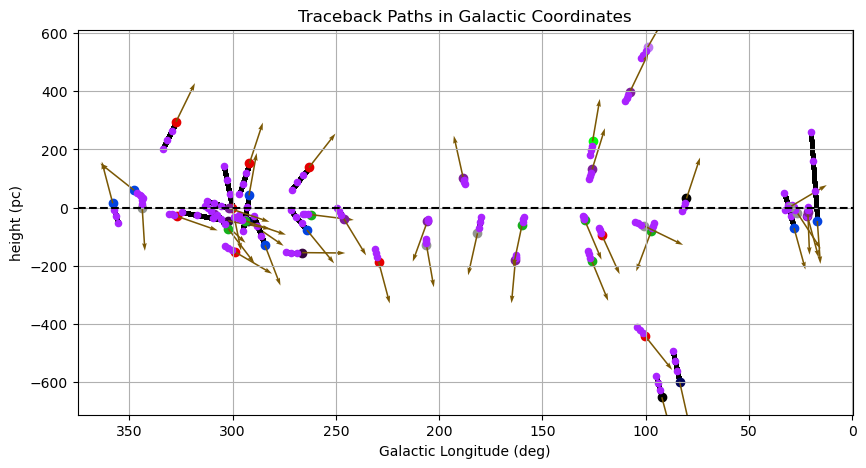

In [31]:
GalacticTraceback(leaving_stars).plot_trace(savefig=True)

In [32]:
approaching_stars_mask = HMXB_trace['Trace Time'] < 0
approaching_stars = HMXB_trace[approaching_stars_mask]

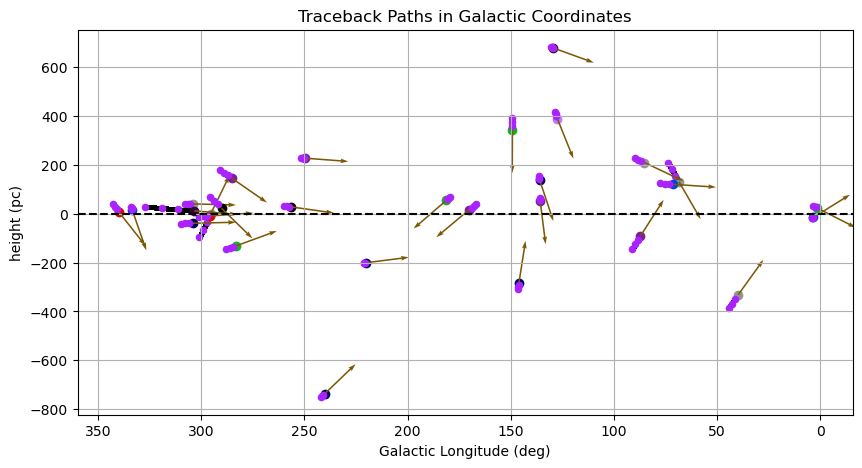

In [33]:
GalacticTraceback(approaching_stars).plot_trace(savefig=False)